In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
import warnings
warnings.filterwarnings("ignore")
import datetime

import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans



In [23]:
df = pd.read_csv('data.csv', encoding= 'unicode_escape')

In [24]:
df["InvoiceDate"] = pd.to_datetime(df['InvoiceDate'])

In [25]:
df['InvoiceRevenue'] = df['Quantity'] * df['UnitPrice']

In [26]:
df = df.query('UnitPrice > 0 and Quantity > 0')
df = df[df['CustomerID'].notna()]
df.shape

(397884, 9)

In [27]:
df['Quartiles'] = pd.cut(df.InvoiceRevenue,5)
df['PercentileRank'] = df.InvoiceRevenue.rank(pct=True)
df['Rank'] = df.InvoiceRevenue.rank()

In [28]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceRevenue,Quartiles,PercentileRank,Rank
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,"(-168.469, 33693.921]",0.624769,248585.5
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,"(-168.469, 33693.921]",0.787735,313427.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,"(-168.469, 33693.921]",0.811120,322731.5
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,"(-168.469, 33693.921]",0.787735,313427.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,"(-168.469, 33693.921]",0.787735,313427.0


In [29]:
df_recency = df[['InvoiceDate','CustomerID']].groupby('CustomerID')['InvoiceDate'].agg('max').reset_index()

df_recency.head()

,CustomerID,InvoiceDate
0,12346.0,2011-01-18 10:01:00
1,12347.0,2011-12-07 15:52:00
2,12348.0,2011-09-25 13:13:00
3,12349.0,2011-11-21 09:51:00
4,12350.0,2011-02-02 16:01:00


In [30]:
cur_time = df_recency['InvoiceDate'].max()
def month_diff(cur_time, datetime_value):
    #Calcula a quantidade de meses entre a data de referência e última compra do usuário
    return 12 * (cur_time.year-datetime_value.year) + (cur_time.month - datetime_value.month)

df_recency['Recency'] = df_recency['InvoiceDate'].apply(lambda datetime_value:month_diff(cur_time,datetime_value))

df_recency = df_recency.drop("InvoiceDate", axis = 1)
df_recency.head()

,CustomerID,Recency
0,12346.0,11
1,12347.0,0
2,12348.0,3
3,12349.0,1
4,12350.0,10


In [31]:
df_fm = df[['CustomerID','InvoiceNo','InvoiceRevenue']]

df_fm = df_fm.groupby('CustomerID')[['InvoiceNo','InvoiceRevenue']].agg({'InvoiceNo':'count', 'InvoiceRevenue': 'mean'})

df_fm = df_fm.rename(columns={'InvoiceNo':'Frequency', 'InvoiceRevenue':'Monetary'})

df_fm.Monetary = df_fm.Monetary.round(2)

df_fm.head()

,Frequency,Monetary
CustomerID,,
12346.0,1,77183.60
12347.0,182,23.68
12348.0,31,57.98
12349.0,73,24.08
12350.0,17,19.67


In [32]:
df_rfv = df_recency.merge(df_fm, on='CustomerID', how='left')

df_rfv = df_rfv.fillna(0)

df_rfv.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,11,1,77183.60
1,12347.0,0,182,23.68
2,12348.0,3,31,57.98
3,12349.0,1,73,24.08
4,12350.0,10,17,19.67


In [33]:
from sklearn.preprocessing import StandardScaler

feature_cols = ['Recency','Frequency','Monetary']

std_data = df_rfv.copy()

scaler = StandardScaler()

scaler.fit(df_rfv[feature_cols])
std_features = scaler.transform(df_rfv[feature_cols])
std_data[feature_cols] = std_features


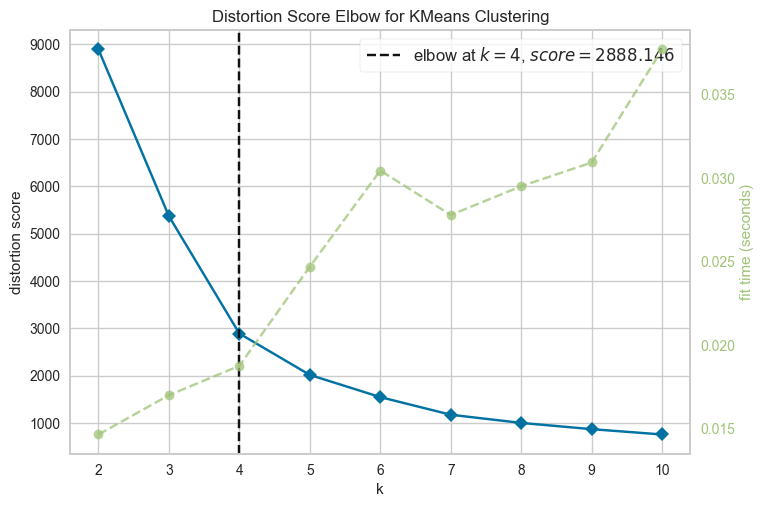

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:

# Dados padronizados
data = std_data[feature_cols]

# Criar uma instância do modelo K-means
model = KMeans(random_state=42)

# Usar o visualizador KElbowVisualizer para encontrar o número ideal de clusters
visualizer = KElbowVisualizer(model, k=(2, 11), metric='distortion')

# Ajustar o visualizador aos dados
visualizer.fit(data)

# Visualizar o gráfico do método do cotovelo
visualizer.show()



In [35]:
from sklearn.cluster import KMeans

# Criar uma instância do modelo K-means com o número de clusters desejado
kmeans = KMeans(n_clusters=4, random_state=42)

# Treinar o modelo com os dados
kmeans.fit(std_data[feature_cols])

# Atribuir os rótulos dos clusters aos dados
df_rfv['clusters']= kmeans.labels_




In [36]:
df_rfv.head()

,CustomerID,Recency,Frequency,Monetary,clusters
0,12346.0,11,1,77183.60,2
1,12347.0,0,182,23.68,0
2,12348.0,3,31,57.98,0
3,12349.0,1,73,24.08,0
4,12350.0,10,17,19.67,1


<AxesSubplot: xlabel='clusters', ylabel='Recency'>

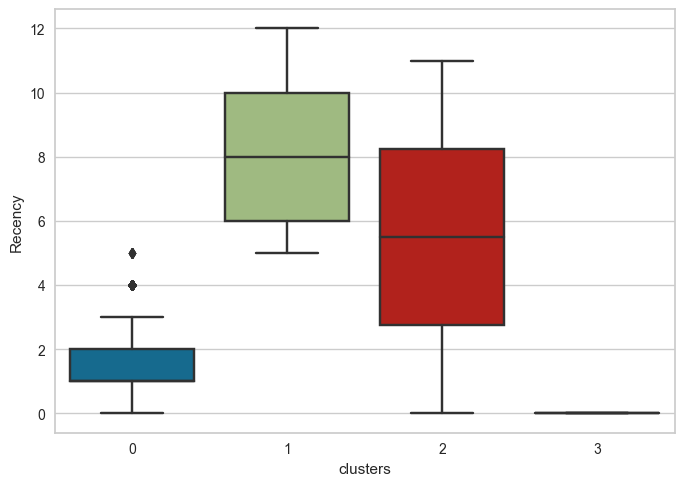

In [37]:
sns.boxplot(x = 'clusters', y = 'Recency', data= df_rfv)

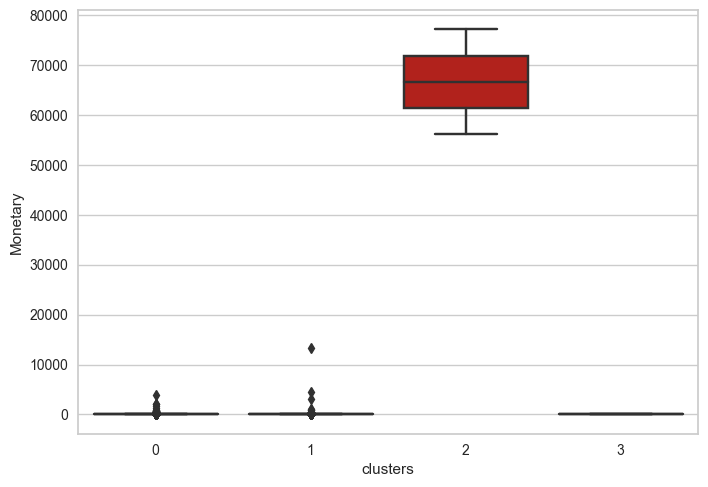

In [38]:
_ = sns.boxplot(x='clusters', y='Monetary', data=df_rfv)

In [39]:
centroid_df = (
    df_rfv.groupby("clusters")
  [["CustomerID", "Recency", "Frequency", "Monetary"]]
    .agg(
        {
          "CustomerID": "nunique",
          "Recency": "mean",
          "Frequency": "mean",
          "Monetary": "mean",  
        }
    )
    .reset_index()
)

# Renomeamos a feature CustomerID 
centroid_df = centroid_df.rename(columns={"CustomerID": "N_Buyers"})

# Vamos ordenar por recencia
centroid_df.sort_values(by="Recency", ascending=True)

,clusters,N_Buyers,Recency,Frequency,Monetary
3,3,4,0.000000,5807.000000,12.662500
0,0,3190,1.483072,107.242320,32.535671
2,2,2,5.500000,2.000000,66670.550000
1,1,1142,8.088441,28.501751,51.947215


In [43]:
# NOmeando os grupos
seg_map = [
    
    'Cliente VIP',
    "Possível Churn",
    'Cliente para ser trabalhado',
    "Comprador Frequente"
]

centroid_df['Segment'] = seg_map
centroid_df

,clusters,N_Buyers,Recency,Frequency,Monetary,Segment
0,0,3190,1.483072,107.242320,32.535671,Cliente VIP
1,1,1142,8.088441,28.501751,51.947215,Possível Churn
2,2,2,5.500000,2.000000,66670.550000,Cliente para ser trabalhado
3,3,4,0.000000,5807.000000,12.662500,Comprador Frequente


In [45]:
centroid_df[['Recency','Frequency','Monetary','Segment']].sort_values('Recency')

,Recency,Frequency,Monetary,Segment
3,0.000000,5807.000000,12.662500,Comprador Frequente
0,1.483072,107.242320,32.535671,Cliente VIP
2,5.500000,2.000000,66670.550000,Cliente para ser trabalhado
1,8.088441,28.501751,51.947215,Possível Churn
